## The Persistent Shock Model and Income Expectations

[![badge](https://img.shields.io/badge/Launch%20using%20-Econ--ARK-blue)](https://econ-ark.org/materials/incexpectationexample#launch)

This module creates an example application extending $\texttt{PersistentShockConsumerType}$ from $\texttt{ConsGenIndShockModel}$. It uses the HARK tool $\texttt{GenIncProcessModel}$ (whose documentation you can find [here](https://github.com/econ-ark/DemARK/blob/master/notebooks/IncExpectationExample.ipynb).)

Most simply, it solves a consumption-saving model with shocks that are neither necessarily fully transitory nor fully permanent. Persistent income is tracked as a state variable and follows an AR(1) process.

###  What if beliefs about persistent income differ from actual ?

What if the consumer has beliefs about the persistence of his/her income process which differ from the *actual* persistence?

We can use the class $\texttt{PersistentShockConsumerType}$ to solve the problem of a consumer with a given set of beliefs, but then simulate a population of consumers for whom that actual persistence differs from what they believe.

(This thought experiment is motivated by an interesting recennt paper presented at the NBER Summer Institute's _Behavioral Macroeconomics Conference_ <cite data-cite="undefined"></cite>

In [1]:
# Initial imports and notebook setup, click arrow to show
%matplotlib inline
import matplotlib.pyplot as plt

import sys
import os
from copy import copy
import numpy as np

from HARK.ConsumptionSaving.ConsGenIncProcessModel import PersistentShockConsumerType
from HARK.distribution import Uniform
from HARK.utilities import get_lorenz_shares, calc_subpop_avg
mystr = lambda number : "{:.4f}".format(number)

In [2]:
# This cell makes a subclass of PersistentShockConsumerType including the MPC 
class PersistentShockConsumerTypeX(PersistentShockConsumerType):
    def getControls(self):
        cLvl = np.zeros(self.AgentCount) + np.nan
        MPCnow = np.zeros(self.AgentCount) + np.nan
        for t in range(self.T_cycle):
            these = t == self.t_cycle
            cLvl[these] = self.solution[t].cFunc(self.state_now["mLvlNow"][these],self.state_now["pLvl"][these])
            MPCnow[these]  =self.solution[t].cFunc.derivativeX(self.state_now["mLvlNow"][these],self.state_now["pLvl"][these])
        self.controls["cLvl"] = cLvl
        self.MPCnow  = MPCnow

In [3]:
# This cell defines a dictionary to make an instance of "persistent shocks" consumer for the infinite horizon model
BaselineDict = {
        "CRRA": 2.0,                           # Coefficient of relative risk aversion
        "Rfree": 1.01/(1.0 - 1.0/160.0),       # Interest factor on assets
        "DiscFac": 0.97,                       # Default intertemporal discount factor
        "LivPrb" : [1.0 - 1.0/160.0],          # Survival probability
        "AgentCount" : 10000,                  # Number of agents of this type (only matters for simulation)
        "IndL": 10.0/9.0,                      # Labor supply per individual (constant)
        "aNrmInitMean" : np.log(0.00001),      # Mean of log initial assets (only matters for simulation)
        "aNrmInitStd"  : 0.0,                  # Standard deviation of log initial assets (only for simulation)
        "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income (only matters for simulation)
        "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income (only matters for simulation)
        "PermGroFacAgg" : 1.0,                 # Aggregate permanent income growth factor (only matters for simulation)
        "T_age" : 400,                         # Age after which simulated agents are automatically killed
        "T_cycle" : 1,                         # Number of periods in the cycle for this agent type
        "T_sim":1200,                          # Number of periods to simulate (idiosyncratic shocks model, perpetual youth)
        "aXtraMin" : 0.001,                    # Minimum end-of-period "assets above minimum" value
        "aXtraMax" : 30,                       # Maximum end-of-period "assets above minimum" value               
        "aXtraExtra" : [0.005,0.01],           # Some other value of "assets above minimum" to add to the grid
        "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
        "aXtraCount" : 48,                     # Number of points in the grid of "assets above minimum"
        "PermShkCount" : 7,                    # Number of points in discrete approximation to permanent income shocks
        "TranShkCount" : 7,                    # Number of points in discrete approximation to transitory income shocks
        "PermShkStd" : [(0.01*4/11)**0.5],     # Standard deviation of permanent shocks to income
        "TranShkStd" : [(0.01*4)**0.5],        # Standard deviation of transitory shocks to income
        "UnempPrb" : 0.05,                     # Probability of unemployment while working
        "UnempPrbRet" : 0.005,                 # Probability of "unemployment" while retired
        "IncUnemp" : 0.3,                      # Unemployment benefits replacement rate
        "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
        "tax_rate" : 0.0,                      # Flat income tax rate
        "T_retire" : 0,                        # Period of retirement (0 --> no retirement)
        "BoroCnstArt" : 0.0,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
        "CubicBool" : False,                   # Use cubic spline interpolation when True, linear interpolation when False
        "vFuncBool" : True,                    # Whether to calculate the value function during solution    
        "cycles": 0,                           # Make this type have an infinite horizon
        "pLvlPctiles" : np.concatenate(([0.001, 0.005, 0.01, 0.03], np.linspace(0.05, 0.95, num=19),[0.97, 0.99, 0.995, 0.999])),
        "PermGroFac" :[1.000**0.25],           # Permanent income growth factor (no perm growth)                   
        "PrstIncCorr": 0.99,                   # Serial correlation coefficient for persistence of income
    }

In [4]:
# This cell defines a function to solve and simulate a consumer misperceiving the correlation of persistent income shocks
def runRoszypalSchlaffmanExperiment(CorrAct, CorrPcvd, DiscFac_center, DiscFac_spread):
    '''
    Solve and simulate a consumer type who misperceives the extent of serial correlation
    of persistent shocks to income.
    
    Parameters
    ----------
    CorrAct : float
        Serial correlation coefficient for *actual* persistent income.
    CorrPcvd : float
        List or array of *perceived* persistent income.
    DiscFac_center : float
        A measure of centrality for the distribution of the beta parameter, DiscFac.
    DiscFac_spread : float
        A measure of spread or diffusion for the distribution of the beta parameter.


    Returns
    -------
    AggWealthRatio: float
        Ratio of Aggregate wealth to income.
    Lorenz: numpy.array
        A list of two 1D array reprensenting the Lorenz curve for assets in the most recent simulated period.
    Gini: float
        Gini coefficient for assets in the most recent simulated period.
    Avg_MPC: numpy.array
        Average marginal propensity to consume by income quintile in the latest simulated period.
    
    '''     
    
    # Make a dictionary to construct our consumer type
    ThisDict = copy(BaselineDict)
    ThisDict['PrstIncCorr'] = CorrAct
    
    # Make a 7 point approximation to a uniform distribution of DiscFac
    DiscFac_list = Uniform(bot=DiscFac_center-DiscFac_spread,top=DiscFac_center+DiscFac_spread).approx(N=7).X
    
    type_list = []
    # Make a PersistentShockConsumerTypeX for each value of beta saved in DiscFac_list
    for i in range(len(DiscFac_list)):    
        ThisDict['DiscFac'] = DiscFac_list.flatten()[i]    
        ThisType = PersistentShockConsumerTypeX(**ThisDict)
              
        # Make the consumer type *believe* he will face a different level of persistence
        ThisType.PrstIncCorr = CorrPcvd
        ThisType.update_pLvlNextFunc() # Now he *thinks* E[p_{t+1}] as a function of p_t is different than it is
    
        # Solve the consumer's problem with *perceived* persistence 
        ThisType.solve()
    
        # Make the consumer type experience the true level of persistence during simulation
        ThisType.PrstIncCorr = CorrAct
        ThisType.update_pLvlNextFunc()
    
        # Simulate the agents for many periods
        ThisType.T_sim = 100
        #ThisType.track_vars = ['cLvl','aLvl','pLvl','MPCnow']
        ThisType.initialize_sim()
        ThisType.simulate()
        type_list.append(ThisType)
    
    # Get the most recent simulated values of X = cLvl, MPCnow, aLvl, pLvl for all types   
    cLvl_all = np.concatenate([ThisType.controls["cLvl"] for ThisType in type_list])
    aLvl_all = np.concatenate([ThisType.state_now["aLvl"] for ThisType in type_list])
    MPC_all = np.concatenate([ThisType.MPCnow for ThisType in type_list])
    pLvl_all = np.concatenate([ThisType.state_now["pLvl"] for ThisType in type_list])
    
    # The ratio of aggregate assets over the income
    AggWealthRatio = np.mean(aLvl_all) / np.mean(pLvl_all)

    # first 1D array: Create points in the range (0,1)
    wealth_percentile = np.linspace(0.001,0.999,201)

    # second 1D array: Compute Lorenz shares for the created points
    Lorenz_init = get_lorenz_shares(aLvl_all, percentiles=wealth_percentile)

    # Stick 0 and 1 at the boundaries of both arrays to make it inclusive on the range [0,1]
    Lorenz_init = np.concatenate([[0],Lorenz_init,[1]])
    wealth_percentile = np.concatenate([[0],wealth_percentile,[1]])
    
    # Create a list of wealth_percentile 1D array and Lorenz Shares 1D array
    Lorenz  = np.stack((wealth_percentile, Lorenz_init))

    # Compute the Gini coefficient
    Gini = 1.0 - 2.0*np.mean(Lorenz_init[1])
    
    # Compute the average MPC by income quintile in the latest simulated period
    Avg_MPC = calc_subpop_avg(MPC_all, pLvl_all, cutoffs=[(0.0,0.2), (0.2,0.4),  (0.4,0.6), (0.6,0.8), (0.8,1.0)])
    
    return AggWealthRatio, Lorenz, Gini, Avg_MPC

The user needs to call the function $\texttt{runRoszypalSchlaffmanExperiment}$ with specific values for $\texttt{CorrAct}$, $\texttt{CorrPcvd}$ and estimates of $\texttt{DiscFac_center}$, $\texttt{DiscFac_spread}$ to solve the model accordingly.



The Lorenz curve for assests is


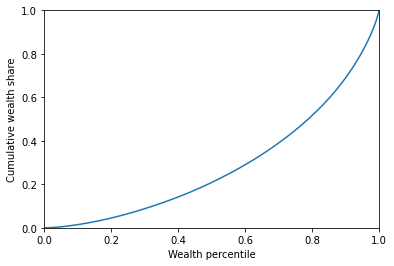

The aggregate wealth to income ratio is 1.9707199243969837
The Gini Coefficient for assests is 1.0
The average MPC by income quintile is [0.10826369336752788, 0.09149385875922972, 0.08823077477926179, 0.07884869047452475, 0.04691684183348368]


In [5]:
# Call the function with test values for (CorrAct, CorrPcvd, DiscFac_center, DiscFac_spread)
AggWealthRatio, Lorenz, Gini, Avg_MPC = runRoszypalSchlaffmanExperiment(0.97, 0.9831,  0.9867, 0.0067)

# Plot the Lorenz curve  
print('The Lorenz curve for assests is')
plt.plot(Lorenz[0],Lorenz[1])
plt.xlabel('Wealth percentile')
plt.ylabel('Cumulative wealth share')
plt.xlim([0.,1.])
plt.ylim([0.,1.])
plt.show()
    
print('The aggregate wealth to income ratio is ' + str(AggWealthRatio))
print('The Gini Coefficient for assests is ' + str(Gini))
print('The average MPC by income quintile is ' + str(Avg_MPC))